# Predicting the daily average temperature

We will build a couple of simple POC models to predict the daily average temperature in California using data from the years 2019 and 2020. For the purpose of this study, we will just focus on univariate time series prediction.

## Data exploration

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error as mse
from neuralprophet import NeuralProphet

from weatherPredict.ts_funcs import stationary_test
from weatherPredict.plotting import ARIMA_predict_plot

In [2]:
df = pd.read_csv(os.path.join("data", "weather_data.csv")).drop(columns = ['Unnamed: 0'])
df.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"CA, United States",2019-01-01,12.7,3.2,6.6,12.7,-1.4,4.1,-4.5,46.5,...,8.0,4,NaN,2019-01-01T07:23:47,2019-01-01T16:55:29,0.91,Clear,Clear conditions throughout the day.,clear-day,"KSMF,72483023232,72483993225,AN063,72483323206..."
1,"CA, United States",2019-01-02,11.1,-1.0,4.6,11.1,-1.0,4.4,0.8,78.0,...,7.5,4,NaN,2019-01-02T07:23:54,2019-01-02T16:56:18,0.95,Clear,Clear conditions throughout the day.,clear-day,"KSMF,72483023232,72483993225,AN063,72483323206..."
2,"CA, United States",2019-01-03,11.6,-0.1,4.8,11.6,-2.0,4.4,1.5,81.0,...,6.9,4,NaN,2019-01-03T07:23:59,2019-01-03T16:57:09,0.97,Clear,Clear conditions throughout the day.,clear-day,"KSMF,72483023232,72483993225,AN063,72483323206..."
3,"CA, United States",2019-01-04,12.7,0.1,5.1,12.7,0.1,5.1,1.9,81.5,...,6.4,4,NaN,2019-01-04T07:24:03,2019-01-04T16:58:01,0.99,Clear,Clear conditions throughout the day.,clear-day,"KSMF,72483023232,72483993225,AN063,72483323206..."
4,"CA, United States",2019-01-05,11.0,2.1,6.9,11.0,1.2,5.3,4.7,86.6,...,0.9,1,NaN,2019-01-05T07:24:04,2019-01-05T16:58:54,1.00,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"KSMF,72483023232,72483993225,AN063,72483323206..."


In [3]:
df.columns

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

We focus on the columns that we are interested in. For now, let's look at the temperature columns and precipitation.

In [4]:
# process
cols_to_keep = [
    'datetime',
    'tempmax',
    'tempmin',
    'temp',
    'precip',
]

df = df[cols_to_keep]
df['datetime'] = pd.to_datetime(df.loc[:,'datetime'])

In [5]:
# lets check for missing values
df.isnull().values.any()
df.isnull().sum()
# there are none so no need to fill entries

datetime    0
tempmax     0
tempmin     0
temp        0
precip      0
dtype: int64

In [6]:
# let's construct some smooth data so it's easier to visualise
df['temp_7day_MA'] = df['temp'].rolling(window = 7).mean()
df['tempmin_7day_MA'] = df['tempmin'].rolling(window = 7).mean()
df['tempmax_7day_MA'] = df['tempmax'].rolling(window = 7).mean()
df['precip_7day_sum'] = df['precip'].rolling(window = 7).sum()

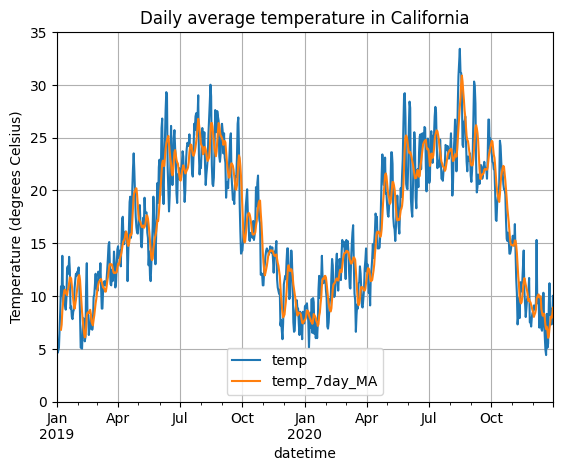

In [7]:
df.plot(x = 'datetime', y = ['temp', 'temp_7day_MA'])
plt.grid();
plt.ylim([0,35]);
plt.title('Daily average temperature in California');
plt.ylabel('Temperature (degrees Celsius)');

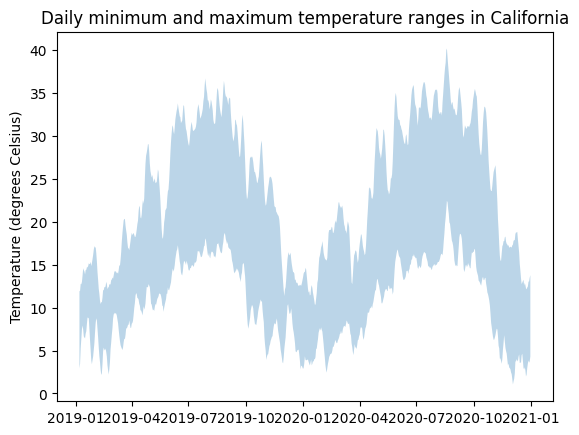

In [8]:
plt.fill_between(df['datetime'], df['tempmin_7day_MA'], df['tempmax_7day_MA'], alpha = 0.3)
plt.title("Daily minimum and maximum temperature ranges in California");
plt.ylabel('Temperature (degrees Celsius)');

Text(0, 0.5, 'Weekly precipitation (mm)')

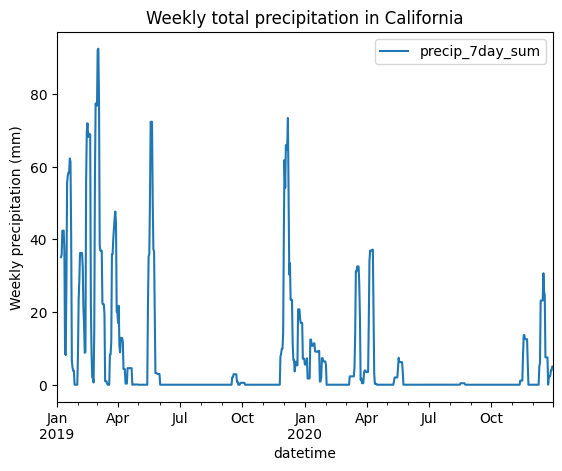

In [9]:
df.plot('datetime', 'precip_7day_sum')
plt.title('Weekly total precipitation in California')
plt.ylabel('Weekly precipitation (mm)')

We see that there is unsurprisinly yearly seasoanality in temperature trends. The daily temperature range remains relatively constant as a proportion of average temperature, and so we will not attempt to predict either of those. Instead we will focus on the daily average tempperature.

Furthermore, it appears there is little regular rain in California. In other words, it rains infrequently. There does appear to be more rain around January than in other times of the year, but there isn't much of a trend. Therefore, it also does not seem appropriate to model precipitation using time series analysis techniques.

## Time Series Analysis

We will explore some of the properties of the time series data, and also explore how to transform the data so it is suitable for an ARIMA model.

In [10]:
df.set_index('datetime', inplace = True)

We can use the statsmodels seasonal decompose function to decompose the time series into a trend and seasonal component, and what the leftover residual is.

Seasonal decompose is not picking up the annual seasonality. However, we would likely need more than two years of data to do this. As a result, the overall trend is still quite noisy.

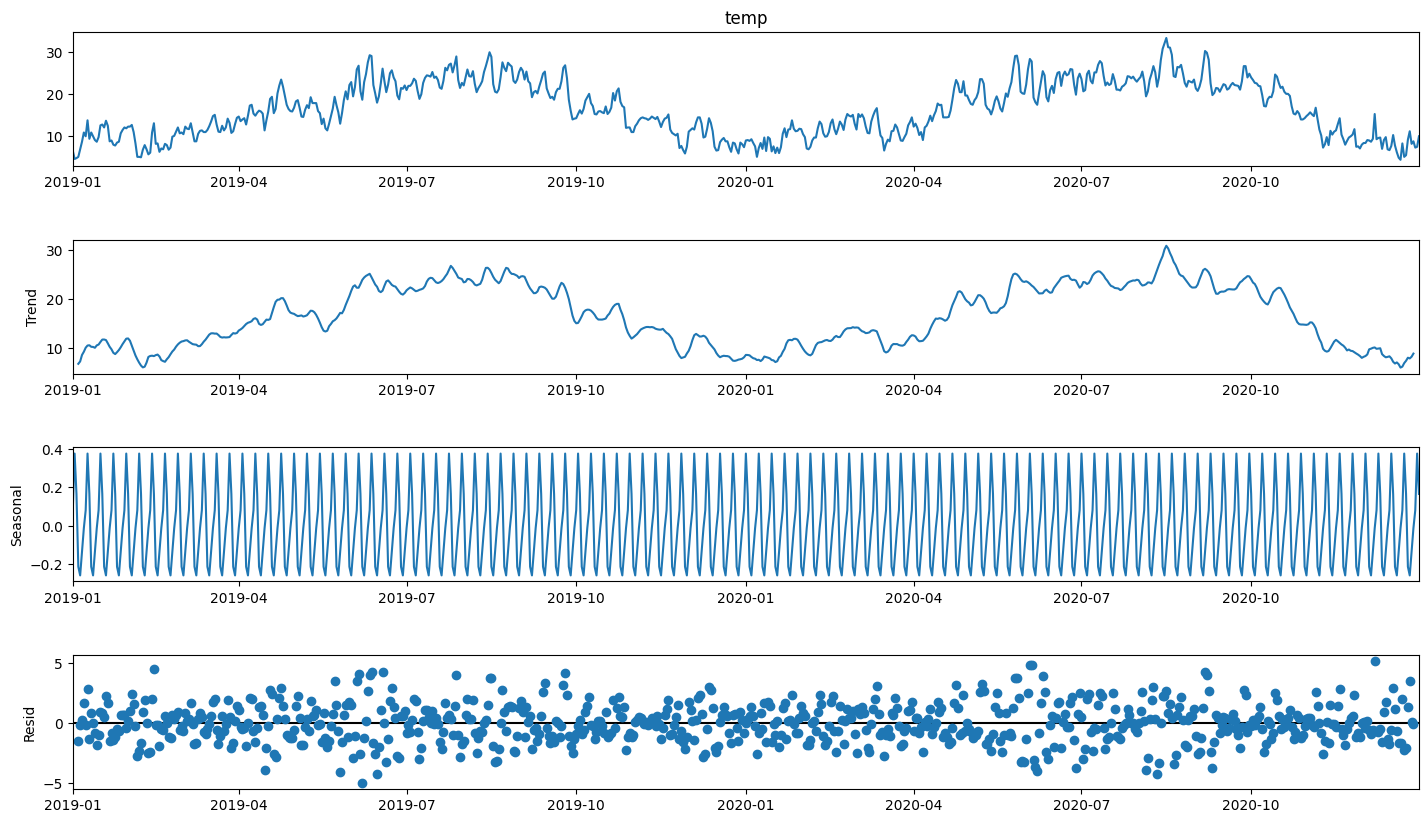

In [11]:
decomposed_data = seasonal_decompose(df['temp'])
fig = decomposed_data.plot();
fig.set_size_inches((16, 9))

ARIMA models require the data to be stationary. Therefore, we perform the Augmented Dicker-Fuller test to test for stationarity.

In [12]:
# evaluate stationarity
stationary_test(df, 'temp')

ADF Statistic: -1.9505555541526471
p-value: 0.30866434140553384
Critical Values:
	1%: -3.4394522667904153
	5%: -2.8655569894909805
	10%: -2.568909106765338


Our threshold p-value is 0.05. As the p-value is greater than 0.05, we fail to reject the null hypothesis that the time-series is non-stationary.

Taking the log of a time series analysis is one way to reduce the deviation from the mean

In [13]:
# data is not stationary
df['log_temp'] = np.log(df['temp'])

<AxesSubplot: xlabel='datetime'>

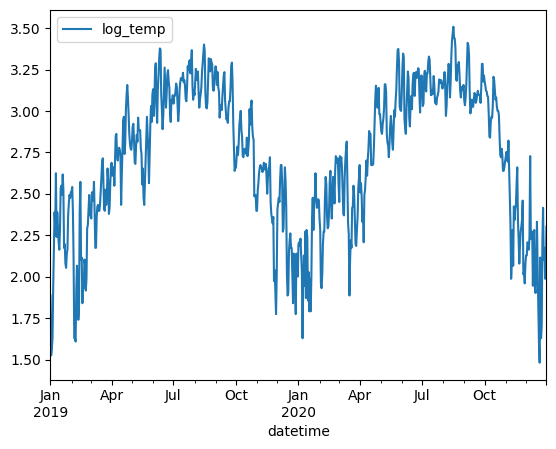

In [14]:
df.plot(y = 'log_temp')

In [15]:
# evaluate stationarity
stationary_test(df, 'log_temp')

ADF Statistic: -1.3248522250018264
p-value: 0.6177270976331406
Critical Values:
	1%: -3.43955476721974
	5%: -2.865602155751202
	10%: -2.5689331692727135


It is still non-stationary.

The d-order of an ARIMA model is the order of differencing used. We want to find the smallest number d such that our time series is stationary. Let's take the first order difference.

In [16]:
df['diff_log_temp'] = df['log_temp'].diff()
stationary_test(df.dropna(), 'diff_log_temp')

ADF Statistic: -8.951771997287539
p-value: 8.684890868286217e-15
Critical Values:
	1%: -3.439620010600208
	5%: -2.8656309041017756
	10%: -2.5689484851894413


Now our p-value < 0.05, so we can reject the null hypothesis, and infer that the time series is now stationary. We plot the difference of the log of the temp below so we can visually verify this.

<AxesSubplot: xlabel='datetime'>

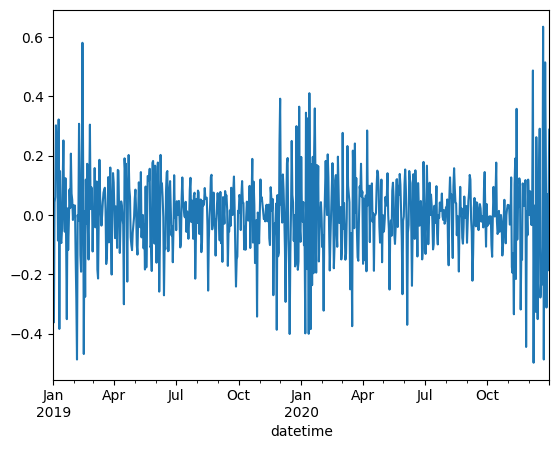

In [17]:
# now it is stationary implying a differencing term of 1 is appropriate
df['diff_log_temp'].plot()

Orders p and q of the ARIMA model can be informed by the autocorrelation and partial autocorrelation figures.

WARNING - (py.warnings._showwarnmsg) - C:\Users\josie\anaconda3\envs\weather_env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(



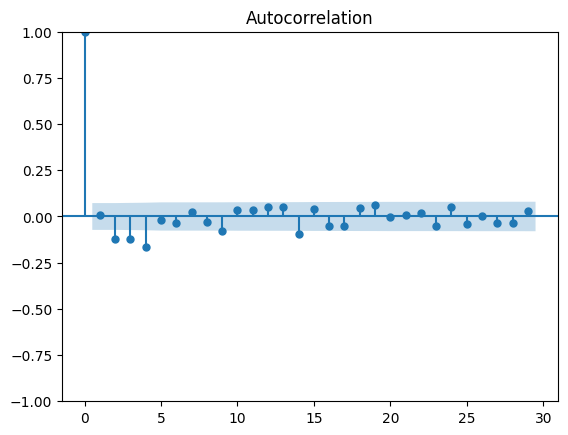

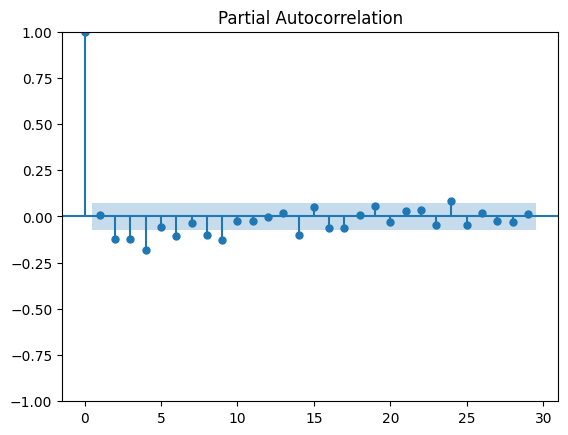

In [18]:
plot_acf(df['diff_log_temp'].dropna());
plot_pacf(df['diff_log_temp'].dropna());

The above implies p and q values of 2, as the first significant value is with lags of 2. We therefore, as a first past, attempt to fit an ARIMA(2,2,1) model.

## Fitting ARIMA models

In [19]:
model = ARIMA(df['log_temp'].values, order=(2,2,1))
model_fit = model.fit()
print(model_fit.summary())

WARNING - (py.warnings._showwarnmsg) - C:\Users\josie\anaconda3\envs\weather_env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  731
Model:                 ARIMA(2, 2, 1)   Log Likelihood                 412.564
Date:                Sun, 30 Oct 2022   AIC                           -817.128
Time:                        09:22:47   BIC                           -798.761
Sample:                             0   HQIC                          -810.042
                                - 731                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0114      0.028      0.414      0.679      -0.043       0.065
ar.L2         -0.1199      0.028     -4.299      0.000      -0.175      -0.065
ma.L1         -0.9998      0.095    -10.470      0.0

Let's see how well the models fits to the data

In [20]:
df['log_temp_predict'] = model_fit.predict()

<AxesSubplot: xlabel='datetime'>

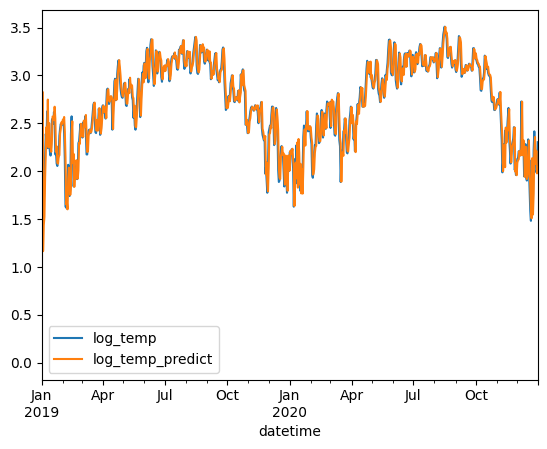

In [21]:
df.plot(y = ['log_temp', 'log_temp_predict'])

It appears as though it is fitting OK. However, this isn't informative as it only tells us it fits to data is has seen but doesn't inform us of the models predictive ability. So we split the data set into a training and test set and fit the model to the training data.

In [22]:
train_df = df.iloc[:650]
test_df = df.iloc[650:]
model = ARIMA(train_df['log_temp'].values, order=(2,2,1))
model_fit = model.fit()

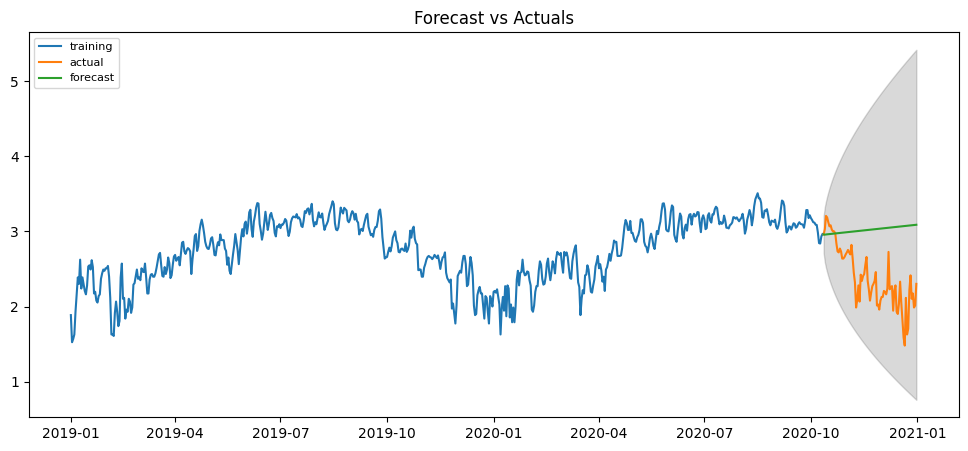

In [23]:
ARIMA_predict_plot(model_fit, train_df, test_df, 'log_temp', model_type = 'ARIMA')

The model is clearly not very good, so let's investigate the accuracy of different ARIMA models. We investigate the following:

* There is seasonality in the data, however a simple ARIMA model does not model seasonalitiy.
* The ARIMA model orders may not be optimal.

Furthermore, there are additional seasonal orders in the SARIMA model, that can be difficult to choose by judgement. Therefore, we using the auto_arima function provided by the pmdarima package that attemptys to identify the optimal SARIMA parameters.

In [24]:
arima_model = auto_arima(train_df['log_temp'])

In [25]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  650
Model:               SARIMAX(3, 1, 1)   Log Likelihood                 449.578
Date:                Sun, 30 Oct 2022   AIC                           -889.155
Time:                        09:23:03   BIC                           -866.778
Sample:                    01-01-2019   HQIC                          -880.475
                         - 10-11-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8464      0.044     19.206      0.000       0.760       0.933
ar.L2         -0.1559      0.035     -4.400      0.000      -0.225      -0.086
ar.L3         -0.0939      0.034     -2.747      0.006      -0.161      -0.027
ma.L1         -0.8540      0.036    -23.434      0.000      -0.925      -0.783
sigma2         0.0146      0.001     24.529      0.000       0.013       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               122.27
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

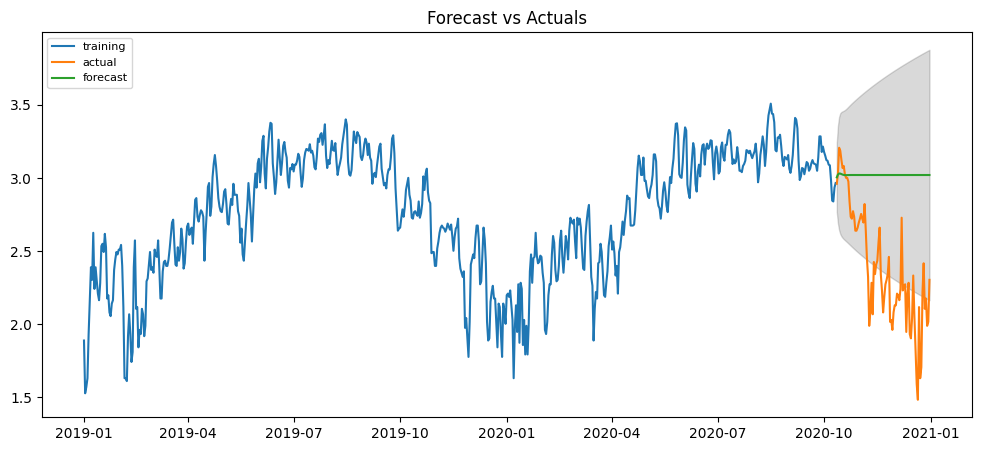

In [26]:
ARIMA_predict_plot(arima_model, train_df, test_df, 'log_temp', model_type = 'auto_arima')

## Exploring the Neural Prophet model.

The ARIMA and SARIMA models did not perform well on our of sample data. So let's try one more different class of model. We use the neural prophet package. This is a development of the fbprophet package.

In [27]:
train_prophet_df = train_df[['log_temp']].reset_index().rename(columns = {'datetime' : 'ds', 'log_temp': 'y'})

In [28]:
#basic model
n1 = NeuralProphet()
model = n1.fit(train_prophet_df, freq='D')

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
WARNING - (py.warnings._showwarnmsg) - C:\Users\josie\anaconda3\envs\weather_env\lib\site-packages\neuralprophet\df_utils.py:193: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\josie\anaconda3\envs\weather_env\lib\site-packages\neuralprophet\df_utils.py:193: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always set

  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.96E-02, min: 1.12E+00


  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.96E-02, min: 1.33E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.08E-02
Epoch[224/224]: 100%|█| 224/224 [00:13<00:00, 16.14it/s, SmoothL1Loss=0.00591, MAE=0.148, RMSE=0.189, Loss=0.00438, Reg


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


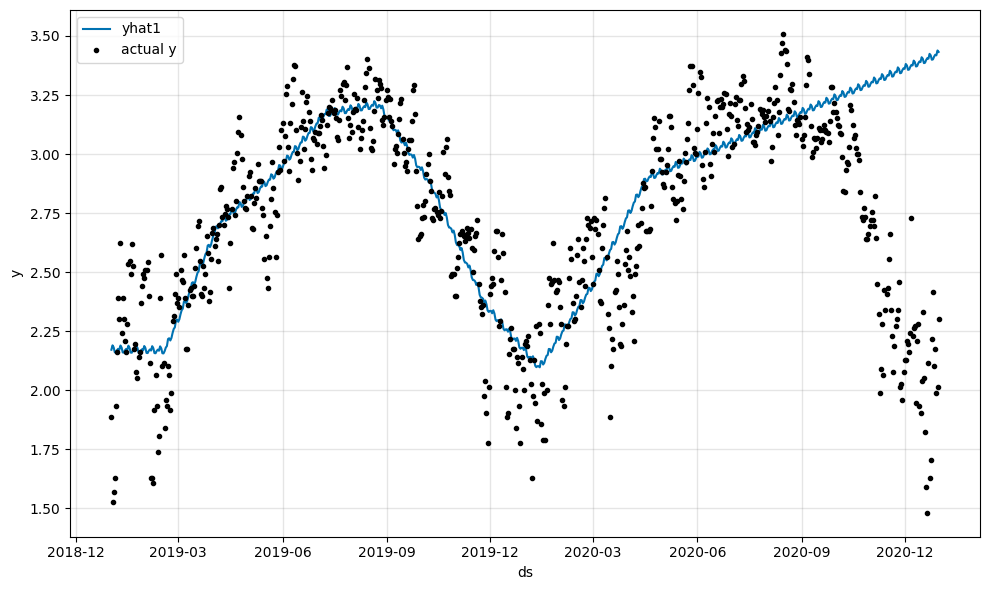

In [29]:
prophet_df = df[['log_temp']].reset_index().rename(columns = {'datetime' : 'ds', 'log_temp': 'y'})
forecast = n1.predict(prophet_df)
forecast.tail()
plot = n1.plot(forecast)

The default model is not very good at fitting out of sample. Let's specify the model with things that we know. We know

* There is yearly seasonality
* There is not daily seasonality
* There is not weekly seasonality
* Over these two years, there is no growth (would be different if we had more data or were projecting over a longer period of time)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
WARNING - (py.warnings._showwarnmsg) - C:\Users\josie\anaconda3\envs\weather_env\lib\site-packages\neuralprophet\df_utils.py:193: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "ds"] = pd.to_datetime(df.loc[:, "ds"])

WARNING - (py.warnings._showwarnmsg) - C:\Users\josie\anaconda3\envs\weather_env\lib\site-packages\neuralprophet\df_utils.py:193: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always set

  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.37E-01, min: 9.44E-01


  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.00E-01, min: 6.68E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.68E-01
Epoch[224/224]: 100%|█| 224/224 [00:09<00:00, 23.51it/s, SmoothL1Loss=0.00565, MAE=0.141, RMSE=0.181, Loss=0.00391, Reg
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.863% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


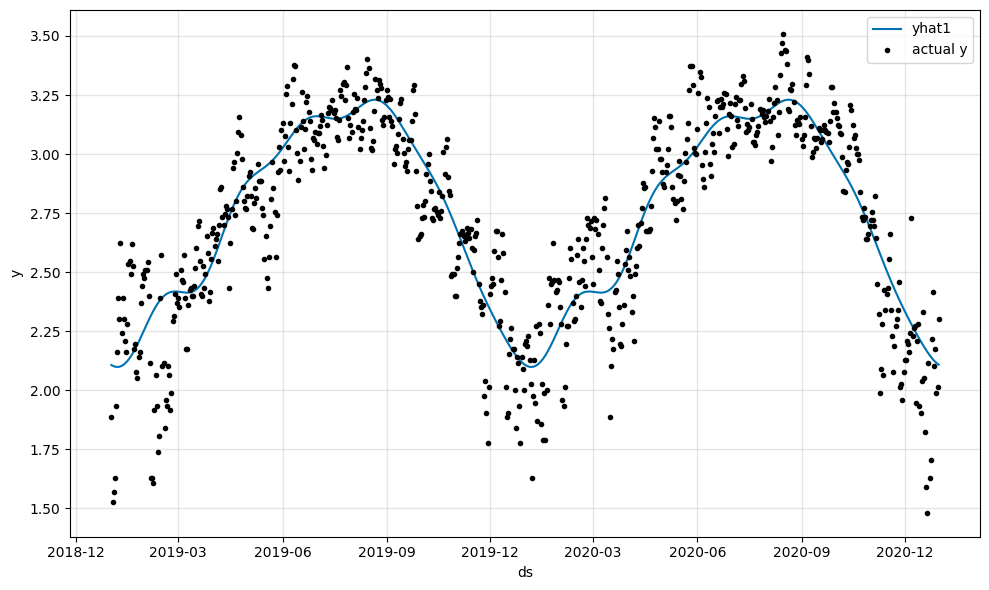

In [30]:
# It is not very good, so let's further specify the model 
#basic model
n2 = NeuralProphet(yearly_seasonality = True, daily_seasonality = False, weekly_seasonality = False, growth = 'off')
model = n2.fit(train_prophet_df, freq='D')
prophet_df = df[['log_temp']].reset_index().rename(columns = {'datetime' : 'ds', 'log_temp': 'y'})
forecast = n2.predict(prophet_df)
forecast.tail()
plot = n2.plot(forecast)

# Model performance evaluation

In [31]:
# models are auto_arima, n1 and n2
train_results_df = train_df[['log_temp']]
train_results_df['arima_predict'] = arima_model.predict_in_sample()
train_results_df['simple_NP'] = n1.predict(train_prophet_df)['yhat1'].values
train_results_df['specified_NP'] = n2.predict(train_prophet_df)['yhat1'].values

test_results_df = test_df[['log_temp']]
test_prophet_df = test_df[['log_temp']].reset_index().rename(columns = {'datetime' : 'ds', 'log_temp': 'y'})
test_results_df['arima_predict'] = arima_model.predict(len(test_df))
test_results_df['simple_NP'] = n1.predict(test_prophet_df)['yhat1'].values
test_results_df['specified_NP'] = n2.predict(test_prophet_df)['yhat1'].values

WARNING - (py.warnings._showwarnmsg) - C:\Users\josie\AppData\Local\Temp\ipykernel_28476\885766402.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_results_df['arima_predict'] = arima_model.predict_in_sample()

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - C:\Users\josie\AppData\Local\Temp\ipykernel_28

In [32]:
print(mse(train_results_df['log_temp'], train_results_df['arima_predict']))
print(mse(train_results_df['log_temp'], train_results_df['simple_NP']))
print(mse(train_results_df['log_temp'], train_results_df['specified_NP']))

0.020133159153266883
0.036875481039580715
0.03523970318879227


In [33]:
print(mse(test_results_df['log_temp'], test_results_df['arima_predict']))
print(mse(test_results_df['log_temp'], test_results_df['simple_NP']))
print(mse(test_results_df['log_temp'], test_results_df['specified_NP']))

0.5533310257868267
1.0964100876501013
0.05791011486456492


While the ARIMA model performs better than the neural prophet model on the training set, it doesn't predict out of sample values well.
The correctly specified neural prophet model performs much better out of sample.
This emphasises the importances of cross-validation.

## Conclusions and suggested next steps for modelling

### Use of exogeneous variables

Time series prediction assumes that the variable of interest can be explained by its past values. In the case of daily everage temperatures. We know this to not be the case. Therefore, we could use other variables to help us explain temperature. For example, wind speed, precipitation, humidity, temperature in neighbouring areas, etc.

### More data

We only have data for two years. This is clearly not enough. For the purpose of this project, I only used 2 years of data due to query limits on visual crossing, but inferring yearly seasonality would be difficult with just 2 years of data, though the nerual prophet model did ok.

### Use of CO2 levels

If we had more data, we would start to see a net upwards trend in temperature. This is correlated with CO2 levels. We could use CO2 as a feature, but also we can use projections of CO2 emissions to help predict future temperature.

## Deployment

### Observing data drift

It is not unlikely that daily average temperatures could drift outside of the previously observed ranges. This will need to be monitored, and models re-trained accordingly.